In [13]:
import pandas as pd

In [6]:
cd ..

/Users/tavishipriyam/Desktop/sem4/EVs


In [14]:
df = pd.read_csv("colorado.csv")


In [18]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tavishipriyam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
mdf = df

In [19]:
mdf['sent'] = mdf['body'].apply(lambda review: sid.polarity_scores(review))
mdf['compound']  = mdf['sent'].apply(lambda score_dict: score_dict['compound'])
mdf['comp_score'] = mdf['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


In [21]:
mdf.to_csv("co_sent.csv")

In [9]:
data = df

In [10]:
data

,Unnamed: 0,author,body,subreddit,score
0,2037,Ok_Cantaloupe3793,i drove a 2013 leaf 25 miles one way in colora...,electricvehicles,4.0
1,3986,ToddA1966,the problem is that incentives skew the origin...,electricvehicles,10.0
2,4196,SubaruToyotaFan1986,in order to keep the timeline as a close-enoug...,AskReddit,1.0
3,5164,ToddA1966,interesting... i asked my leaf dealer in color...,electricvehicles,3.0
4,5212,california_malice,"you're close, but i think there will be some b...",stocks,1.0
...,...,...,...,...,...
9084,3139533,MultiSourceNews_Bot,more coverage at:\r\n\r\n\r\n\r\n* [colorado ...,NewsfeedForWork,1.0
9085,3145174,fuckyousquirtle,"no offense, but what you said is basically thi...",denvernuggets,3.0
9086,3145664,stefanrowles96,"same can be said in the us, the uk is about 70...",AskAnAmerican,-4.0
9087,3145721,aelwero,right... harley davidson is now an entity in ...,electricvehicles,1.0


In [11]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http','https','zpxvxdlj','co','rt','ev','evs','electric','car','vehicle','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
!pip3 install -U spacy


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [12]:
data

,Unnamed: 0,author,body,subreddit,score
0,2037,Ok_Cantaloupe3793,i drove a 2013 leaf 25 miles one way in colora...,electricvehicles,4.0
1,3986,ToddA1966,the problem is that incentives skew the origin...,electricvehicles,10.0
2,4196,SubaruToyotaFan1986,in order to keep the timeline as a close-enoug...,AskReddit,1.0
3,5164,ToddA1966,interesting... i asked my leaf dealer in color...,electricvehicles,3.0
4,5212,california_malice,"you're close, but i think there will be some b...",stocks,1.0
...,...,...,...,...,...
9084,3139533,MultiSourceNews_Bot,more coverage at:\r\n\r\n\r\n\r\n* [colorado ...,NewsfeedForWork,1.0
9085,3145174,fuckyousquirtle,"no offense, but what you said is basically thi...",denvernuggets,3.0
9086,3145664,stefanrowles96,"same can be said in the us, the uk is about 70...",AskAnAmerican,-4.0
9087,3145721,aelwero,right... harley davidson is now an entity in ...,electricvehicles,1.0


In [11]:
def sent_to_words(sentences):
    for sent in sentences:
        if type(sent)!= str:
            continue
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
dataa = data.body.values.tolist()
data_words = list(sent_to_words(dataa))
print(data_words[:1])

[['drove', 'leaf', 'miles', 'one', 'way', 'in', 'colorado', 'for', 'year', 'few', 'years', 'ago', 'it', 'made', 'the', 'commute', 'at', 'mph', 'mostly', 'without', 'issue', 'really', 'cold', 'days', 'were', 'the', 'worst', 'so', 'made', 'use', 'of', 'charger', 'near', 'work', 'about', 'three', 'times', 'most', 'times', 'charged', 'at', 'home', 'overnight', 'and', 'not', 'at', 'work', 'iirc', 'the', 'car', 'has', 'mile', 'range', 'with', 'the', 'kw', 'hr', 'battery', 'we', 'only', 'charged', 'up', 'to', 'to', 'be', 'easy', 'on', 'the', 'battery', 'and', 'when', 'you', 'get', 'down', 'to', 'about', 'the', 'car', 'estimate', 'of', 'remaining', 'miles', 'would', 'go', 'blank', 'so', 'miles', 'of', 'comfortable', 'range', 'also', 'the', 'power', 'to', 'go', 'over', 'eats', 'into', 'the', 'battery', 'so', 'wasn', 'passing', 'people', 'also', 'had', 'to', 'be', 'mindful', 'of', 'spontaneous', 'changes', 'of', 'plans', 'that', 'involved', 'or', 'miles', 'more', 'it', 'not', 'time', 'but', 'dis

In [12]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


In [13]:
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=10,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.010*"people" + 0.009*"thing" + 0.009*"guy" + 0.008*"well" + 0.007*"lose" '
  '+ 0.007*"vote" + 0.007*"pick" + 0.006*"population" + 0.006*"post" + '
  '0.006*"look"'),
 (1,
  '0.031*"city" + 0.019*"amp" + 0.017*"energy" + 0.013*"power" + 0.011*"build" '
  '+ 0.011*"solar" + 0.010*"com" + 0.009*"oil" + 0.008*"system" + 0.008*"bus"'),
 (2,
  '0.024*"state" + 0.018*"year" + 0.014*"new" + 0.011*"cost" + 0.011*"pay" + '
  '0.011*"com" + 0.010*"tax" + 0.009*"emission" + 0.008*"company" + '
  '0.008*"money"'),
 (3,
  '0.022*"charge" + 0.020*"drive" + 0.014*"mile" + 0.014*"time" + '
  '0.009*"charger" + 0.009*"range" + 0.009*"hour" + 0.009*"stop" + 0.008*"way" '
  '+ 0.008*"tesla"')]


In [14]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/181664221.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/181664221.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.9223,"charge, drive, mile, time, charger, range, hou...","[drive, leaf, mile, way, colorado, year, years..."
1,1,3,0.6042,"charge, drive, mile, time, charger, range, hou...","[problem, incentive, skew, original, price, th..."
2,2,3,0.4511,"charge, drive, mile, time, charger, range, hou...","[order, keep, timeline, close, enough, timelin..."
3,3,2,0.5354,"state, year, new, cost, pay, com, tax, emissio...","[interesting, ask, leaf, dealer, effect, price..."
4,4,2,0.3837,"state, year, new, cost, pay, com, tax, emissio...","[close, big, player, manage, organize, retail,..."
5,5,3,0.6934,"charge, drive, mile, time, charger, range, hou...","[point, rental, agency, start, pick, deal, ton..."
6,6,2,0.4201,"state, year, new, cost, pay, com, tax, emissio...","[solar_panel, pay, sure, south, face, roof, ob..."
7,7,3,0.5704,"charge, drive, mile, time, charger, range, hou...","[multiple, variant, multiple, find, pro, duo, ..."
8,8,3,0.3672,"charge, drive, mile, time, charger, range, hou...","[fact, sale, grow, global, pandemic, overall, ..."
9,9,3,0.8389,"charge, drive, mile, time, charger, range, hou...","[garage, sure, keep, charge, winter, plug, nig..."


In [15]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9498,"people, thing, guy, well, lose, vote, pick, population, post, look","[trump, win, nh, still, lose, election, last, state, win, election, still, lose, hillary, keep, ..."
1,1,0.8984,"city, amp, energy, power, build, solar, com, oil, system, bus","[sorry, sunbelt, correct, suburb, virtually, city, north, sunbelt, sunbelt, bulldoze, example, c..."
2,2,0.9696,"state, year, new, cost, pay, com, tax, emission, company, money","[colorado, state, let, apply, tax_credit, payment, lease, deal, month, month, state, new_jersey,..."
3,3,0.9914,"charge, drive, mile, time, charger, range, hour, stop, way, tesla","[ill, half, agree, leaf, great, road_trippe, bolt, math, stack, bolt, charge, little, kwh, minut..."


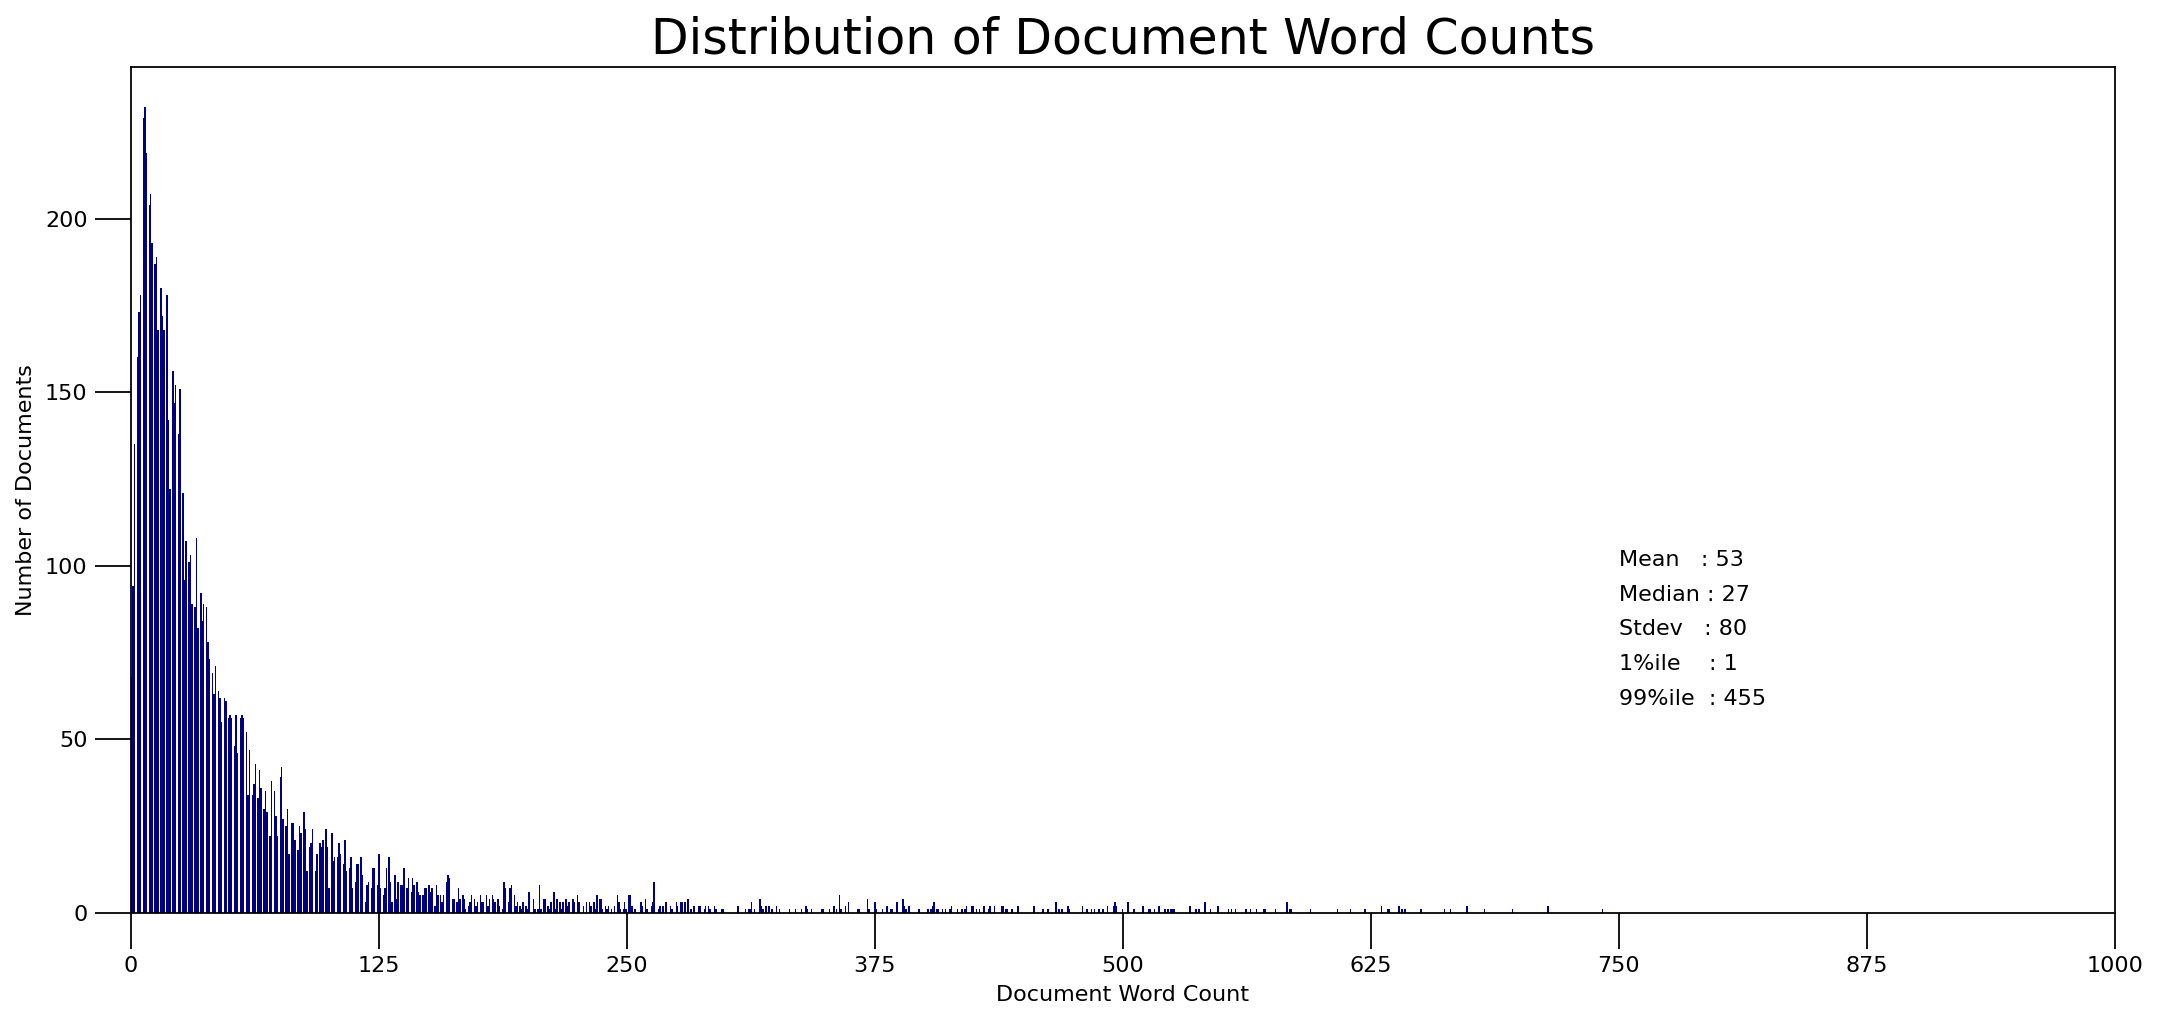

In [16]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/2460086901.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/2460086901.py:

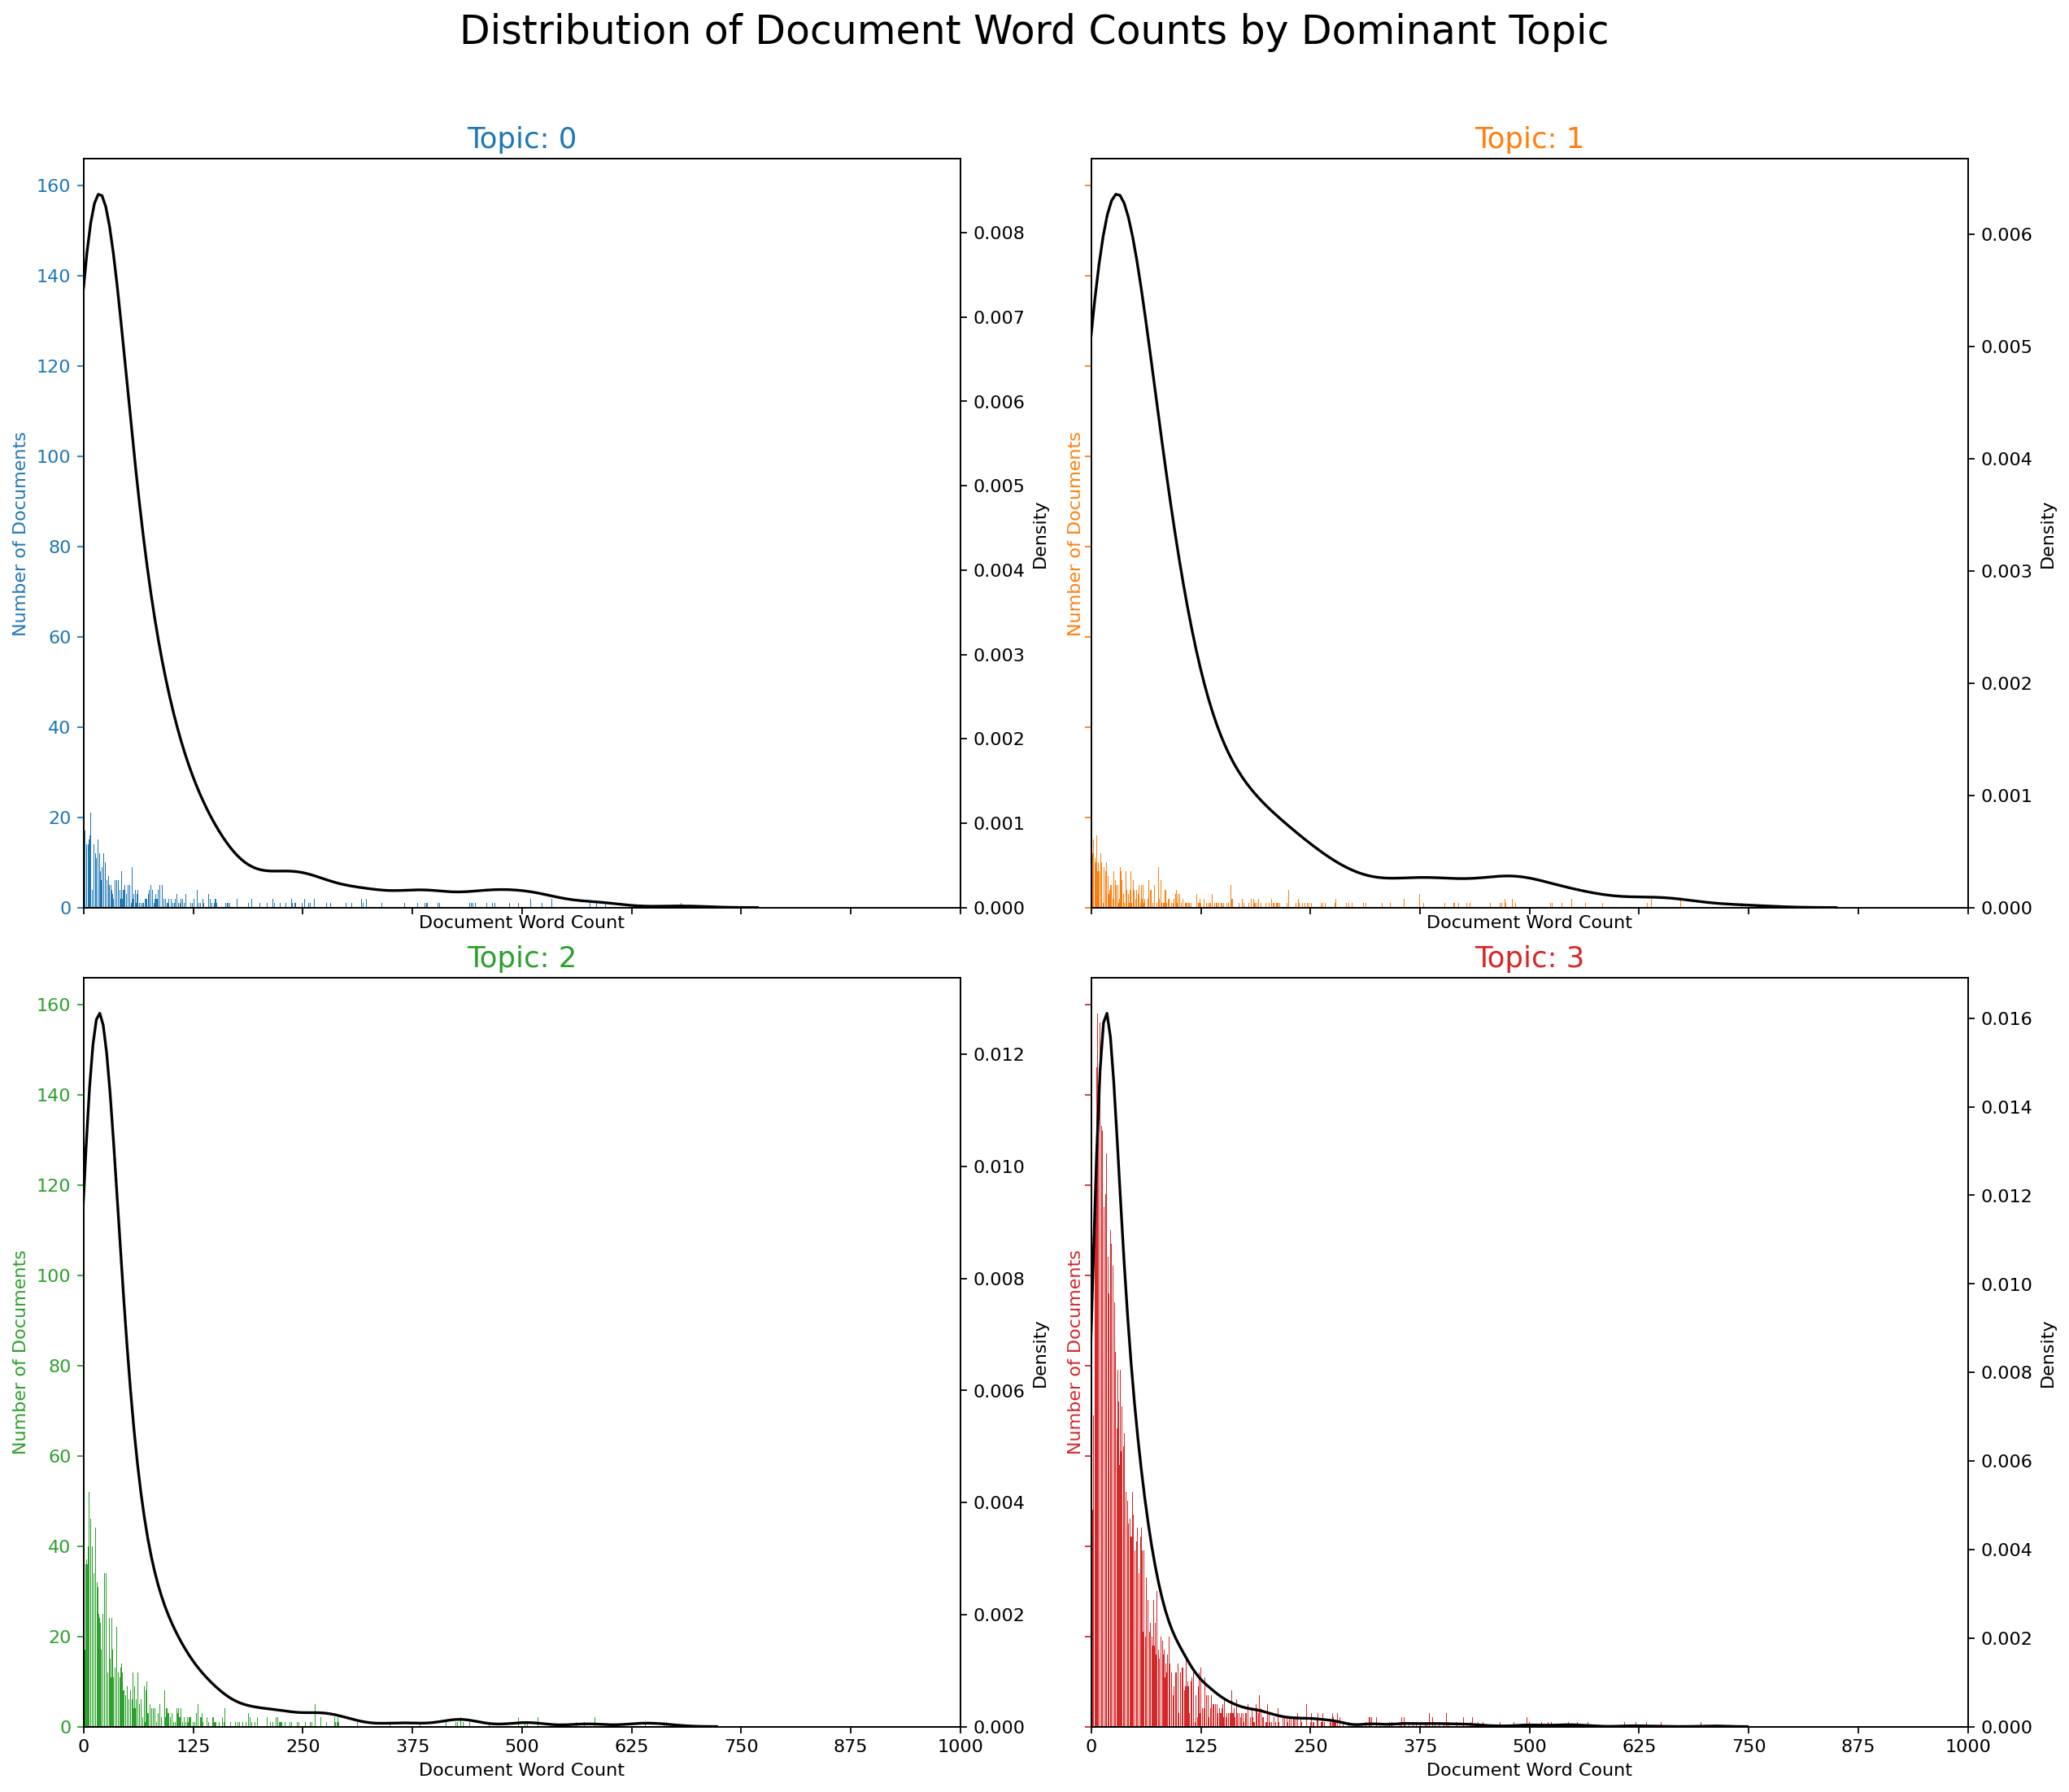

In [17]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

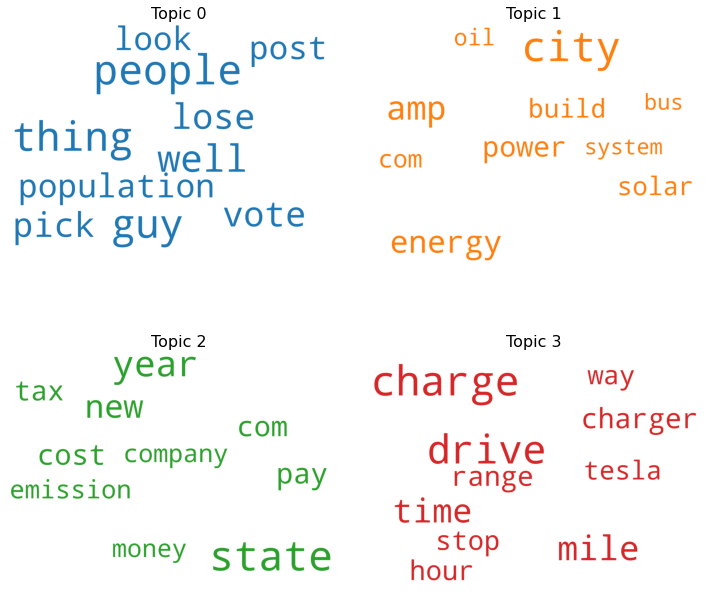

In [18]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [27]:
df.to_csv("colorado_topics.csv")

/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/3335660495.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/3335660495.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/3335660495.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/23/nlj2ws3n7mz6my6588wvrlsw0000gn/T/ipykernel_95273/3335660495.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalig

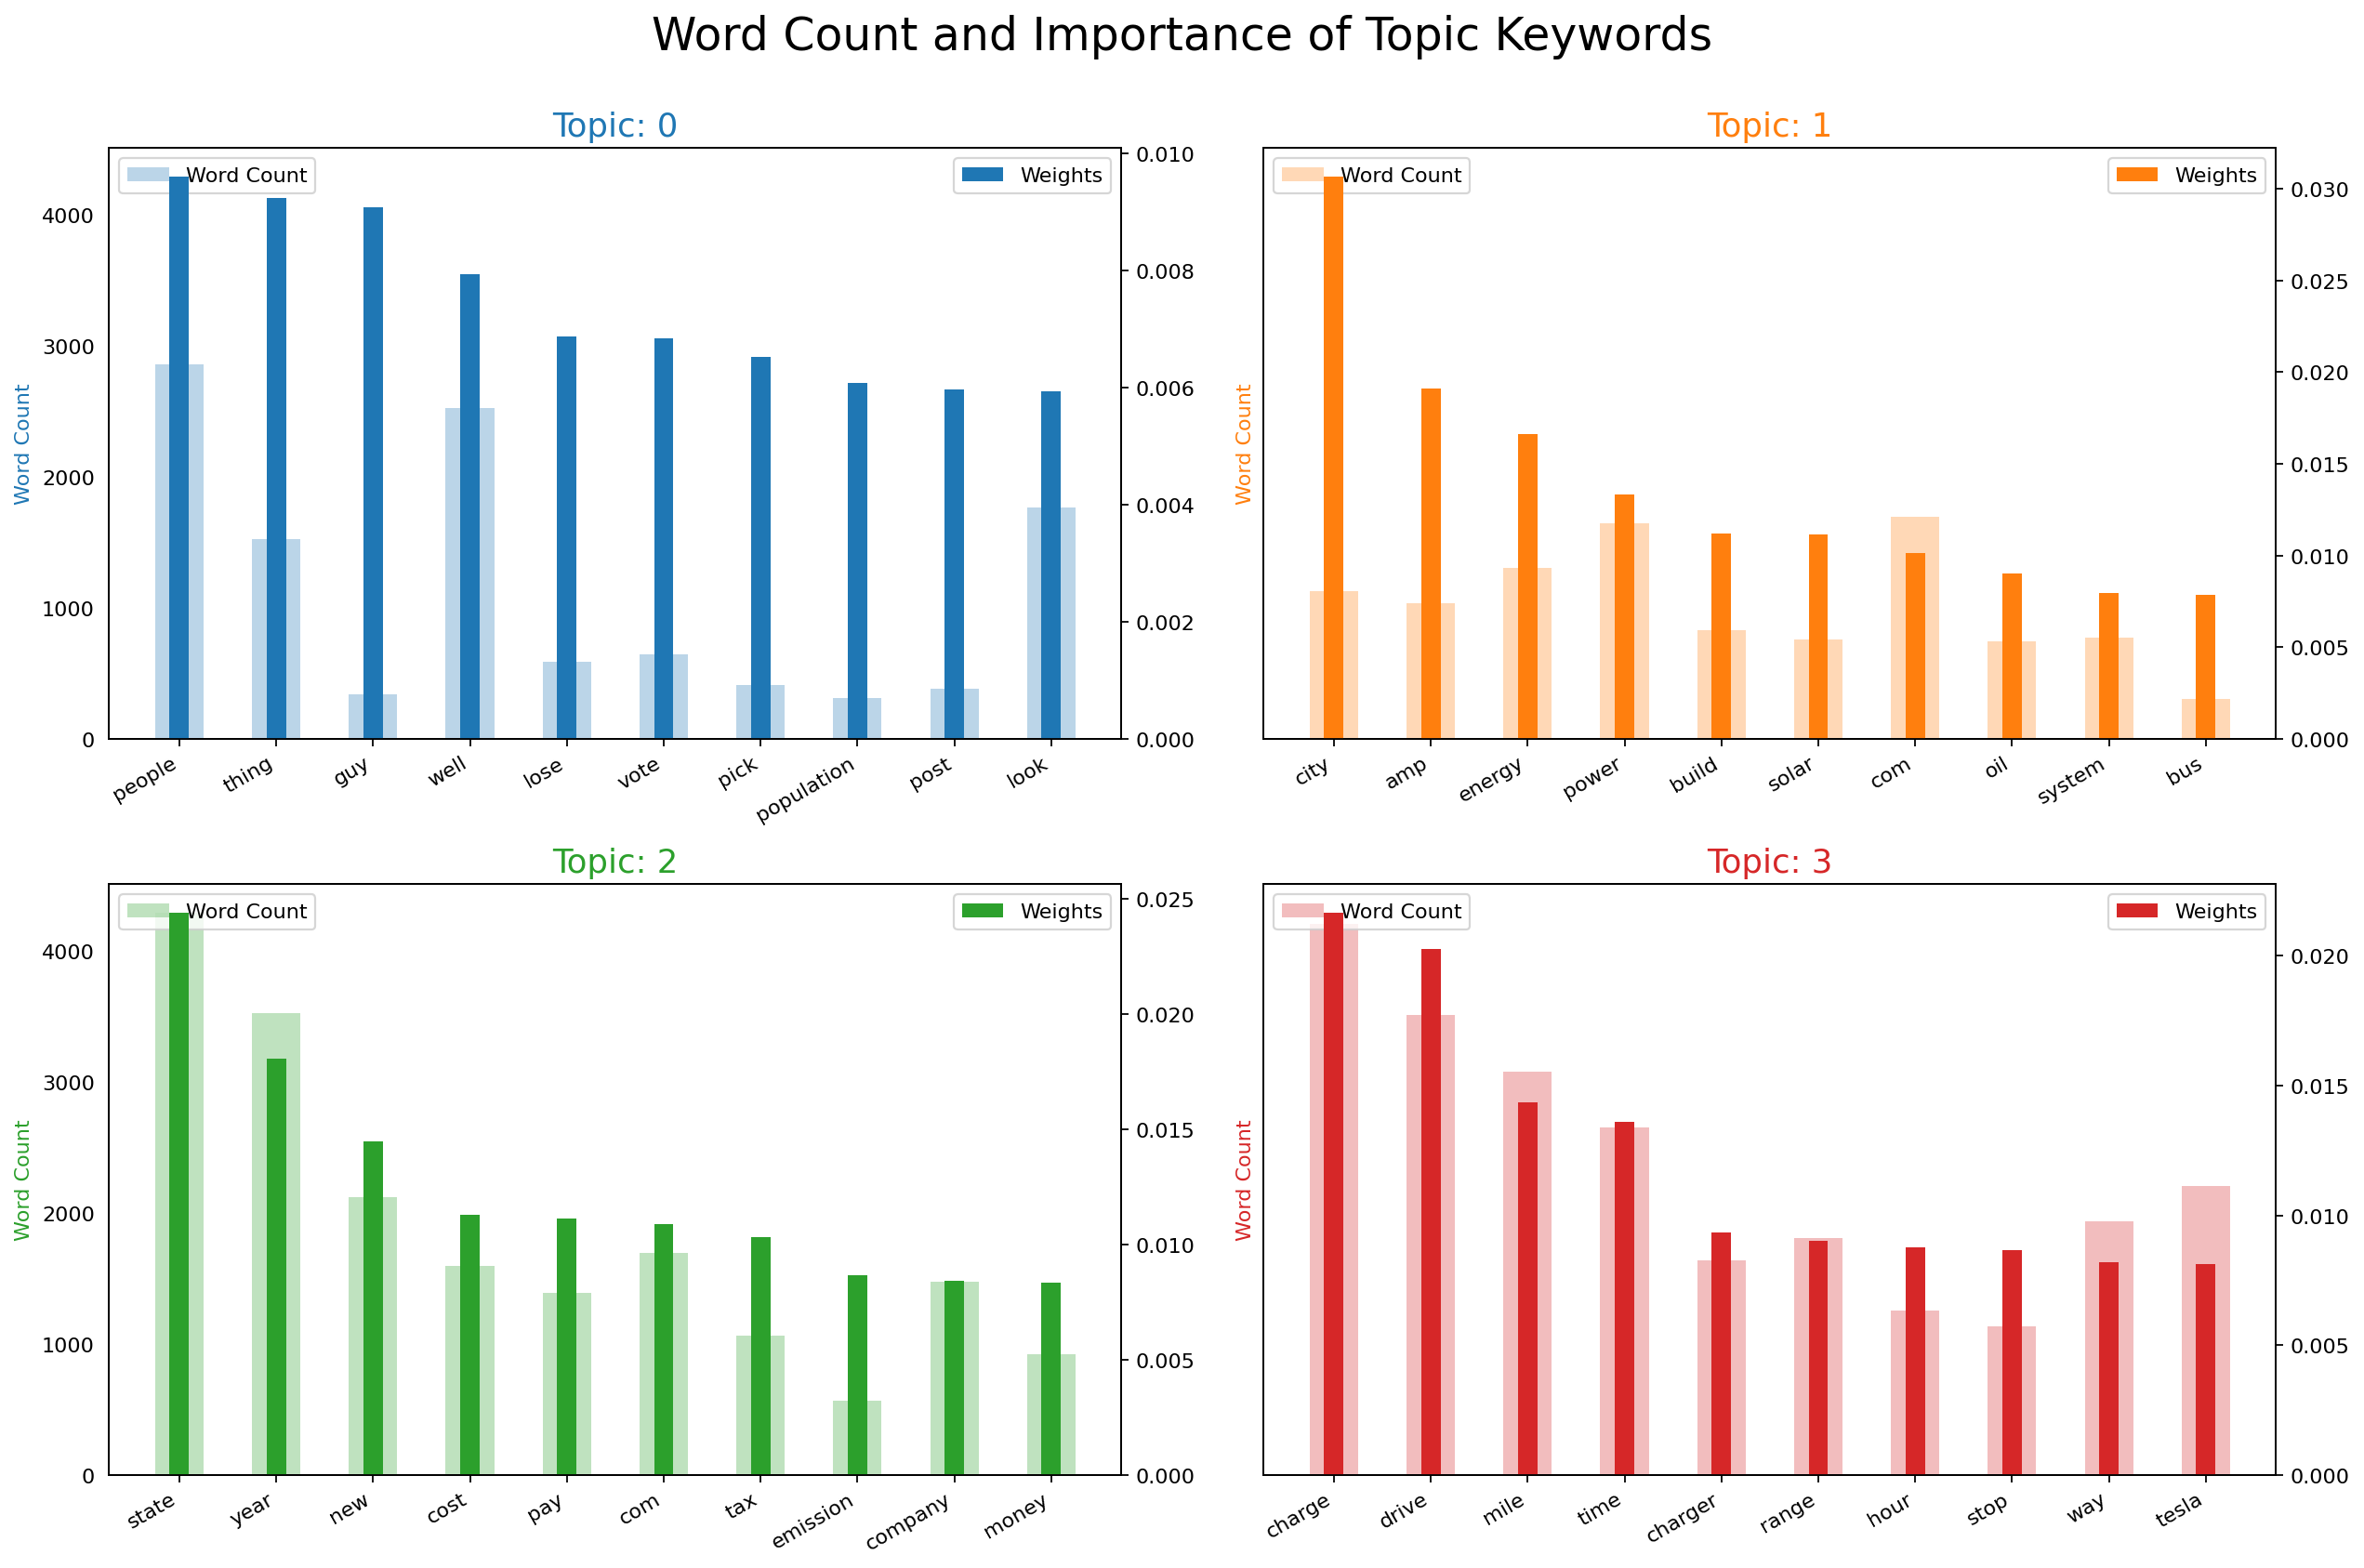

In [25]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [20]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

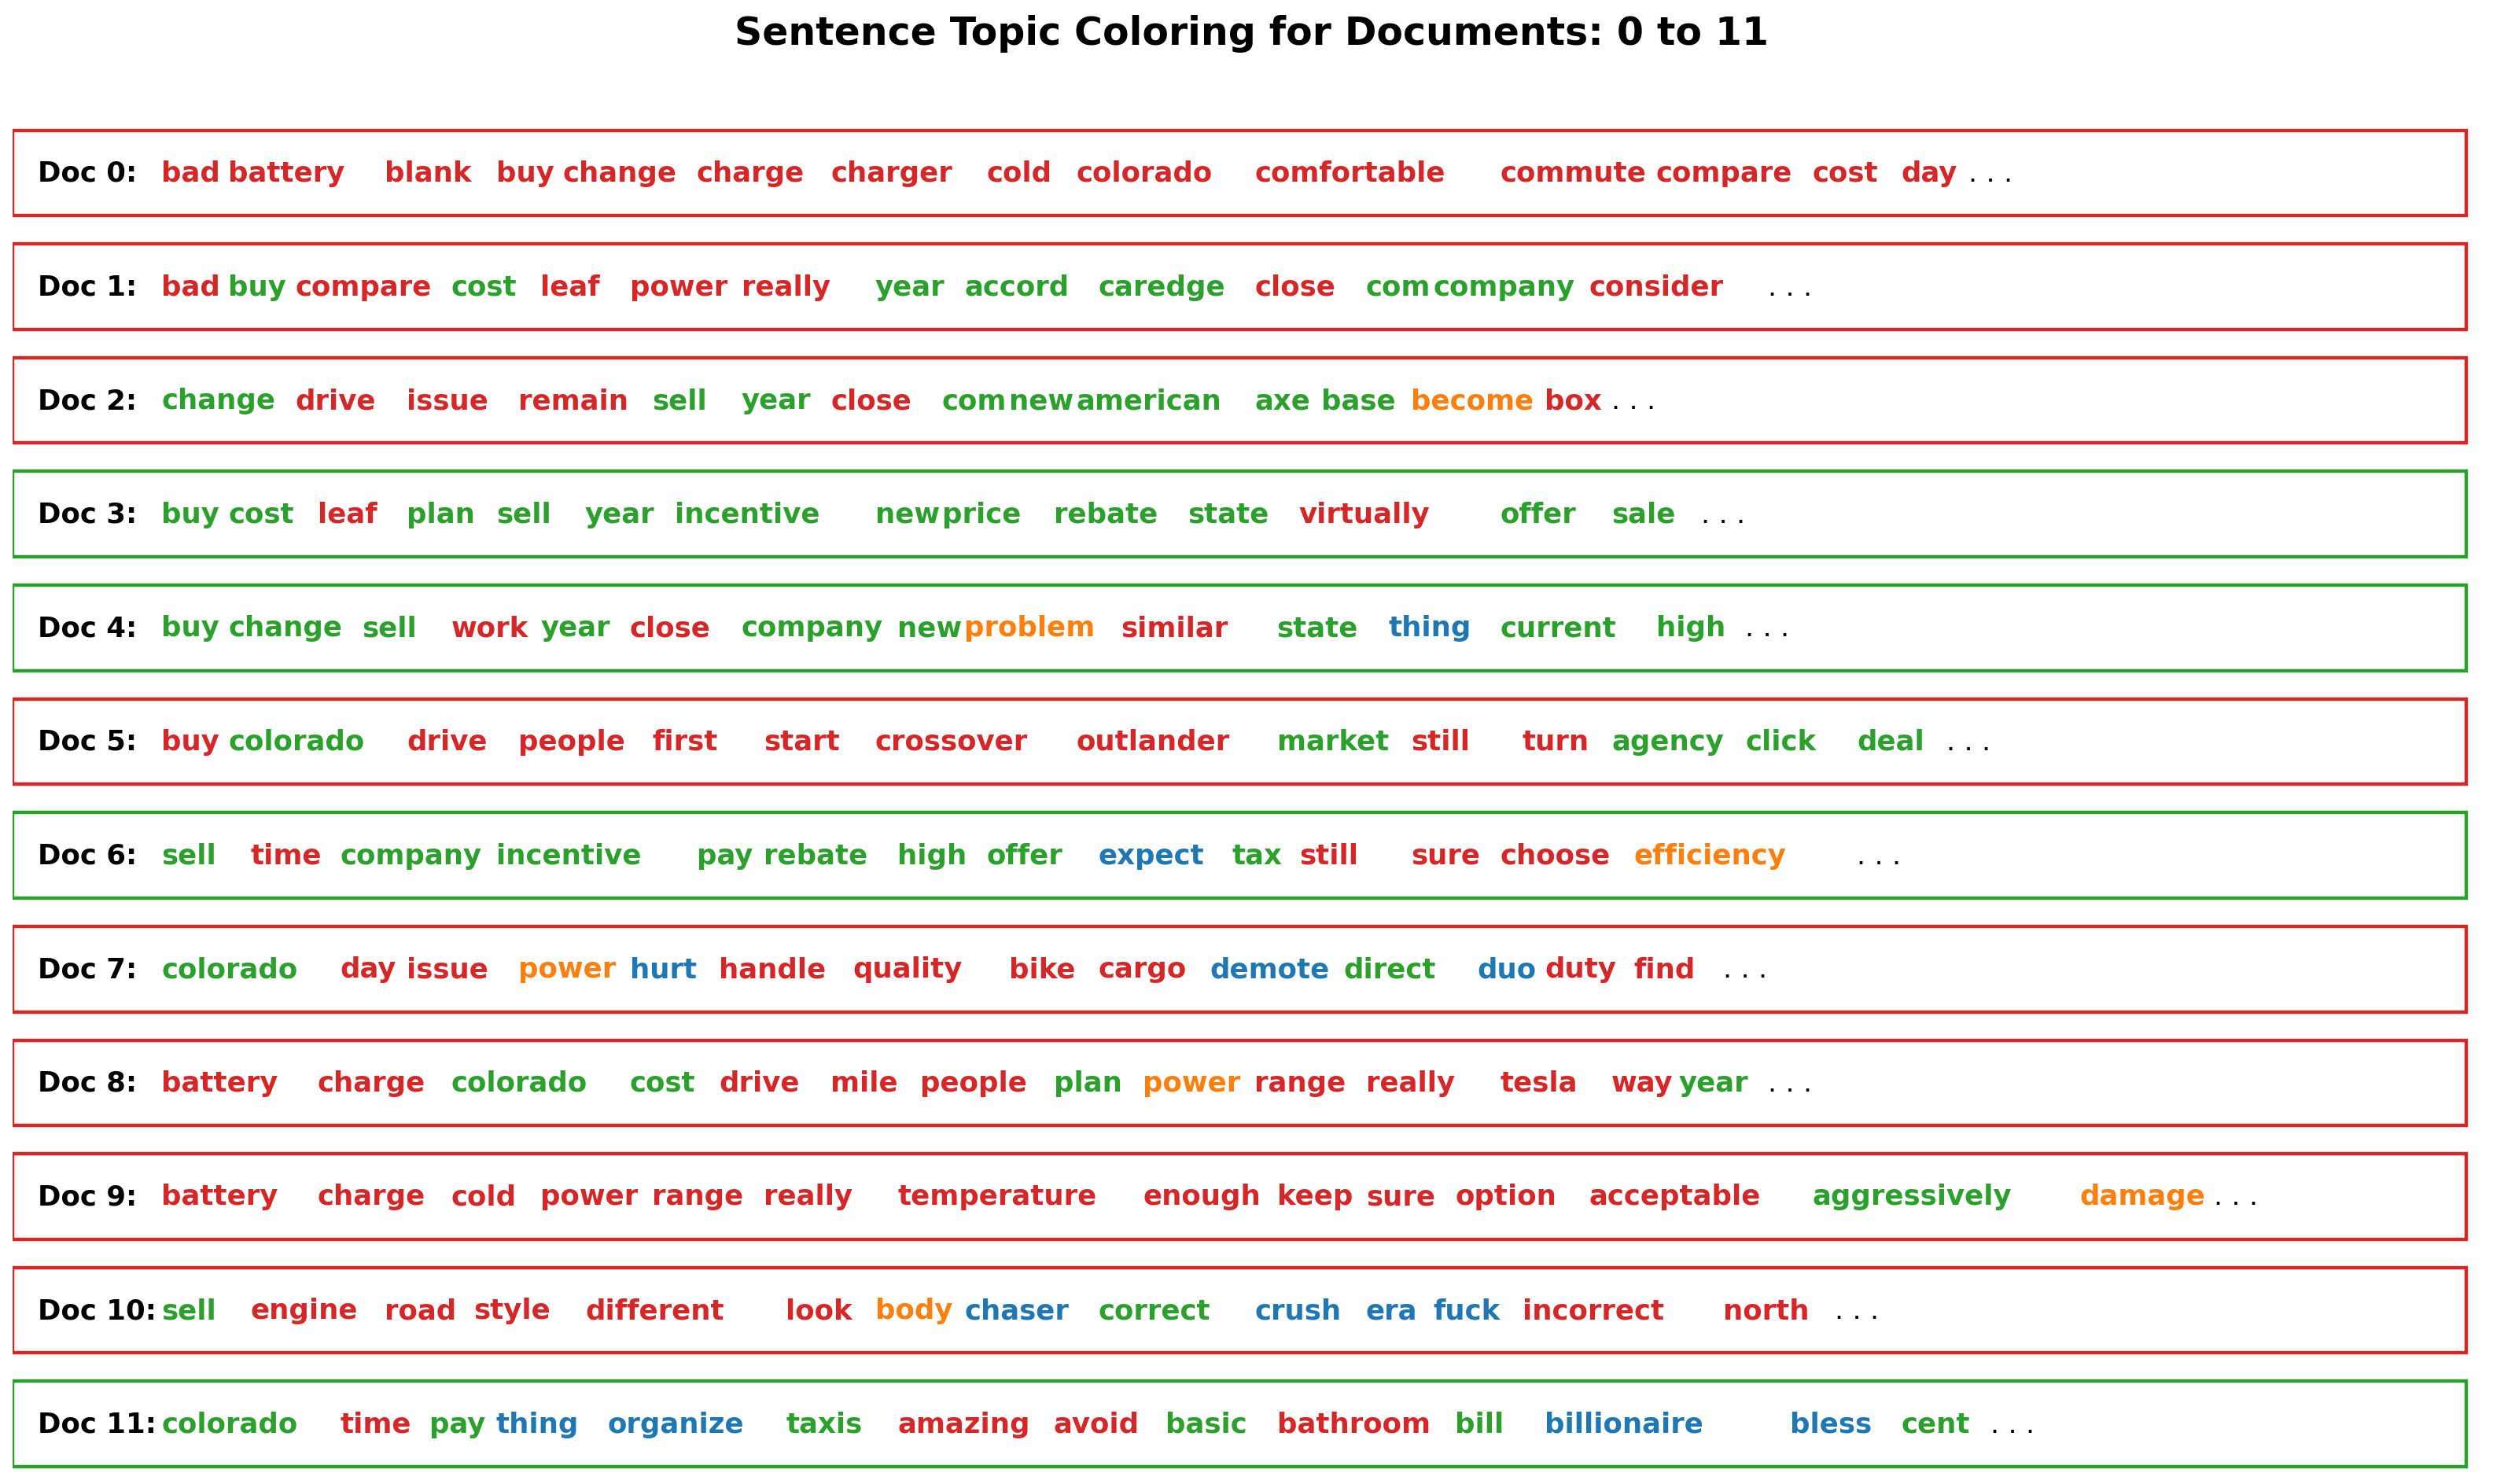

In [21]:
sentences_chart()  

In [22]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

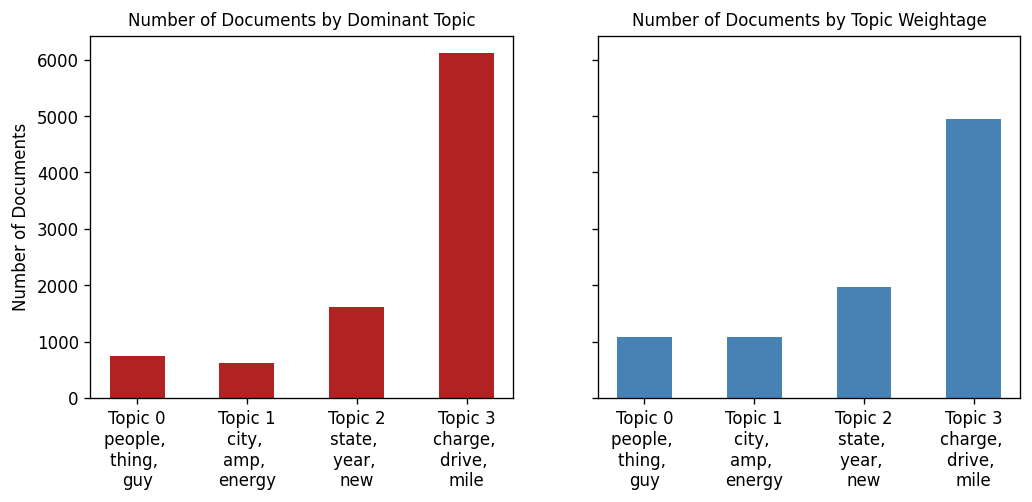

In [23]:
from matplotlib.ticker import FuncFormatter
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [24]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/Users/tavishipriyam/Downloads/ENTER/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8772 samples in 0.004s...
[t-SNE] Computed neighbors for 8772 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8772
[t-SNE] Computed conditional probabilities for sample 2000 / 8772
[t-SNE] Computed conditional probabilities for sample 3000 / 8772
[t-SNE] Computed conditional probabilities for sample 4000 / 8772
[t-SNE] Computed conditional probabilities for sample 5000 / 8772
[t-SNE] Computed conditional probabilities for sample 6000 / 8772
[t-SNE] Computed conditional probabilities for sample 7000 / 8772
[t-SNE] Computed conditional probabilities for sample 8000 / 8772
[t-SNE] Computed conditional probabilities for sample 8772 / 8772
[t-SNE] Mean sigma: 0.001308


/Users/tavishipriyam/Downloads/ENTER/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.412384
[t-SNE] KL divergence after 1000 iterations: 0.959429


Loading BokehJS ...

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [24]:
!pip3 install bokeh


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/tavishipriyam/Downloads/ENTER/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


ImportError: cannot import name 'gensim' from 'pyLDAvis' (/Users/tavishipriyam/Downloads/ENTER/lib/python3.9/site-packages/pyLDAvis/__init__.py)

In [ ]:
!pip3 install pyLDAvis.gensim